In [1]:
import gc
import glob
import os
import sys
import cv2
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from random import randrange
from time import time
from tqdm import tqdm, tnrange
from tqdm.notebook import tqdm_notebook

import warnings

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

from keras.optimizer_v2.gradient_descent import SGD
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers import Dense, MaxPooling2D, Flatten, Conv2D, Lambda, Dropout, LeakyReLU, BatchNormalization, Activation, AveragePooling2D, GlobalAveragePooling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator

from mlxtend.evaluate import accuracy

from tensorflow.keras.optimizers import Adam,RMSprop,SGD, Nadam
#from tensorflow.keras.utils import to_categorical
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.applications import VGG16

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # ignore tensorflow warnings
warnings.filterwarnings("ignore")

In [3]:
path_data = "data/data_palm_vein/NIR"

In [4]:
def load_img(path, xdim=128, ydim=128, nb_of_users = 500):
    label_names = []
    X = []
    y = []
    nb_of_users = nb_of_users - 1
    count = 0
    identity = -1
    directories = os.listdir(path)
    directories.sort()
    for dirname in tqdm_notebook(directories, desc="Loading images..."):
        if dirname == ".DS_Store": continue
        label_names.append(dirname)
        data_path = os.path.join(path + "/" + dirname, '*g')
        files = glob.glob(data_path)
        if identity >= nb_of_users: break
        identity += 1
        files.sort()
        for f1 in files:
            img = cv2.imread(f1, cv2.IMREAD_GRAYSCALE)
            #img = cv2.imread(f1)
            #img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
            img = cv2.resize(img,(int(xdim*1), int(ydim*1)))
            #X.append([np.array(img), np.array(img), np.array(img)])
            #X.append(np.array(img))
            #X.append(np.array(img))
            X.append(np.array(img))
            #stacked_img = np.stack((img,)*3, axis=-1)
            #X.append(stacked_img)
            y.append(identity)
            count += 1
    X = np.array(X)
    y = np.array(y)
    print("\n ================= Summary of extraction ================= \n")
    print(count, ' images lues')
    print("\nX.shape = ", X.shape)
    print("y.shape = ", y.shape)
    gc.collect()
    return X, y, label_names

In [5]:
X, y, label_names = load_img(path_data, nb_of_users=200)

Loading images...:   0%|          | 0/501 [00:00<?, ?it/s]


 ================= Summary of extraction ================= 

2400  images lues

X.shape =  (2400, 128, 128)
y.shape =  (2400,)


In [6]:
X = X / 255.
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
y = to_categorical(y)

print("\nPREPROCESSING DATA")
print("-----------------------------------------")
print("\nX shape : {}".format(X.shape))
print("-----------------------------------------")
print("y shape : {}\n".format(y.shape))
print("\n\n-----------------------------------------")
print("Il y a {} utilisateur(s) dans le dataset prélevé.".format(y.shape[1]))


PREPROCESSING DATA
-----------------------------------------

X shape : (2400, 128, 128, 1)
-----------------------------------------
y shape : (2400, 200)



-----------------------------------------
Il y a 200 utilisateur(s) dans le dataset prélevé.


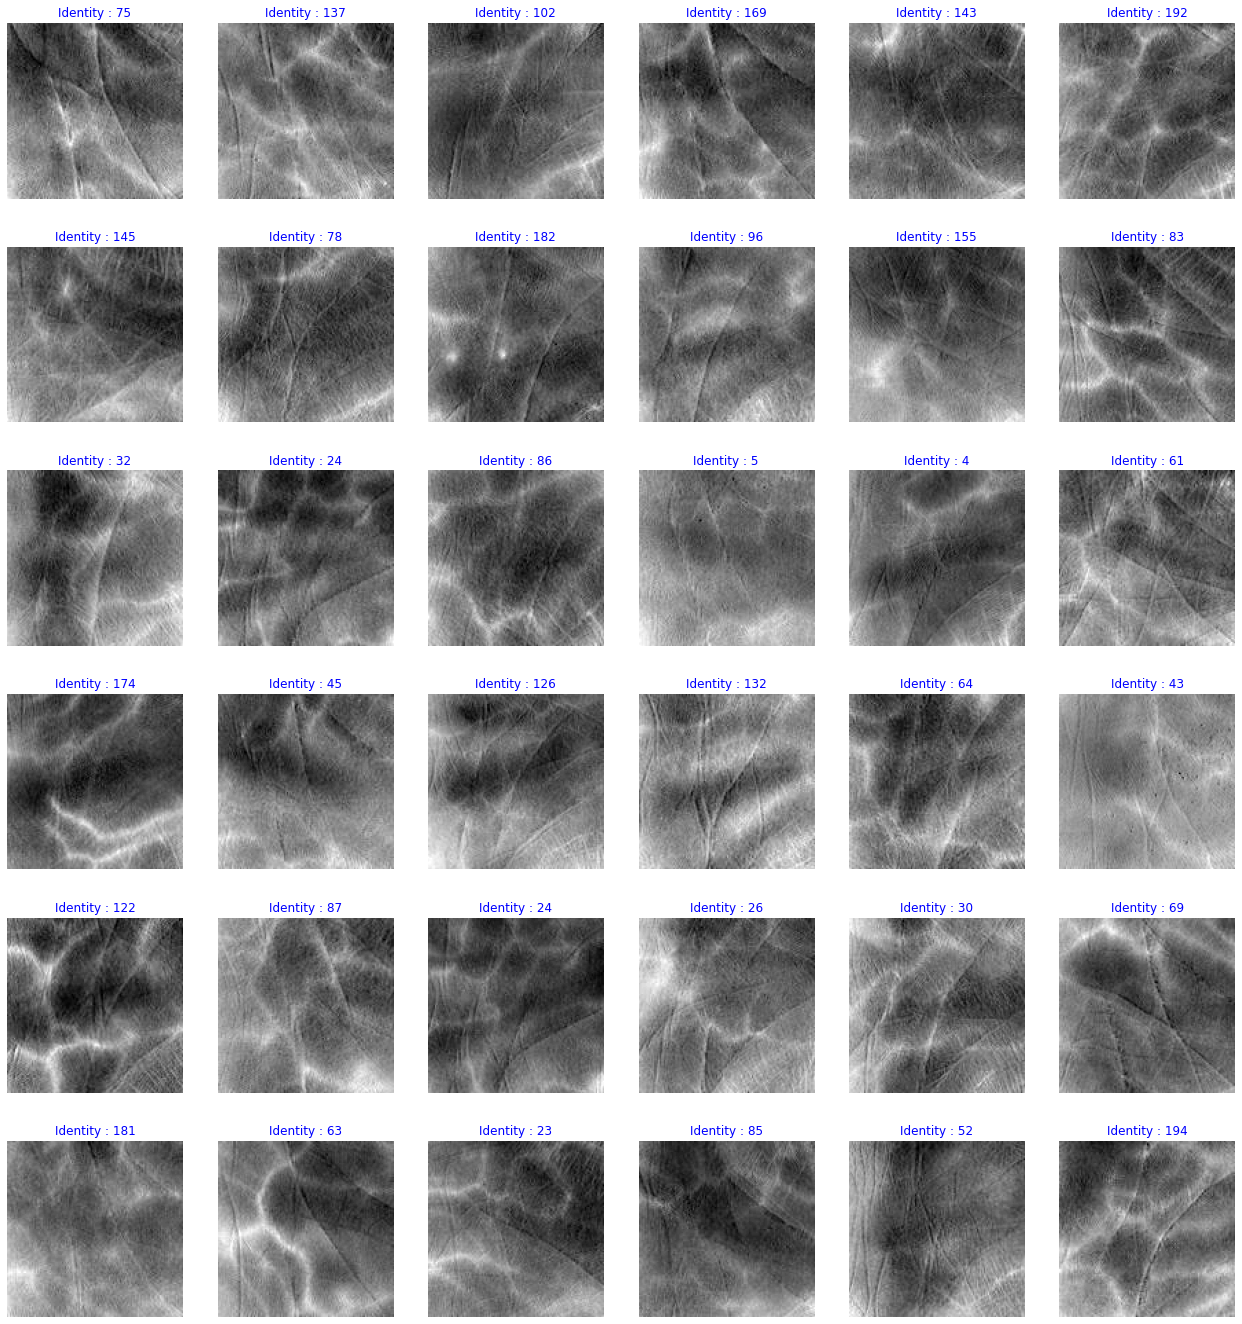

In [7]:
plt.figure(figsize=(22, 24))

for i in range(36):
    ax = plt.subplot(6, 6, i + 1)
    r = randrange(y.shape[0])
    plt.imshow(X[r], cmap=plt.cm.binary)
    title_obj = plt.title("Identity : {}".format(np.argmax(y[r])))
    plt.setp(title_obj, color='blue')
    plt.axis("off")

In [8]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
print("\nSplitting data ...\n")
print("\n=============================== Splitting data =============================== \n")
print("\nX_train shape : {}    |   y_train shape : {}".format(X_train.shape, y_train.shape))
print("------------------------------------------------------------------------------")
print("(X_temp shape : {}    |   y_temp shape  : {})\n".format(X_temp.shape, y_temp.shape))


Splitting data ...


=============================== Splitting data =============================== 


X_train shape : (1920, 128, 128, 1)    |   y_train shape : (1920, 200)
------------------------------------------------------------------------------
(X_temp shape : (480, 128, 128, 1)    |   y_temp shape  : (480, 200))



In [11]:
# function to create the model for Keras wrapper to scikit learn
# we will optimize the type of pooling layer (max or average) and the activation function of the 2nd and 3rd convolution layers 
def create_model(pool_type='max', conv_activation='LeakyReLU', dropout_rate=0.10, classes=500):
    # create model
    model = Sequential()
    # first layer: convolution
    model.add(Conv2D(128, kernel_size=(4, 4), activation='LeakyReLU', input_shape=(128, 128, 1))) 
        
    # second series of layers: convolution, pooling, and dropout
    #model.add(Conv2D(256, kernel_size=(3, 3), activation=conv_activation))  
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate=dropout_rate))     
    
    model.add(Flatten())         
    model.add(Dense(128, activation='LeakyReLU')) # 64
    # add a dropout layer if rate is not null    
    if dropout_rate != 0:
        model.add(Dropout(rate=dropout_rate)) 
        
    model.add(Dense(classes, activation='softmax'))
    
    # Compile model
    model.compile( 
        optimizer='nadam',
        loss='categorical_crossentropy',
        metrics=['accuracy'],
        )
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.7, 
                                            min_lr=0.00000000001)    
    return model

cnn, lr_reduction = create_model(classes=y.shape[1])

cnn.compile(
  optimizer='nadam',
  loss='categorical_crossentropy',  
  metrics=['accuracy'],
)

n_epochs = 50 # 30 
n_epochs_cv = 10 # 10  # reduce number of epochs for cross validation for performance reason

n_cv = 3
validation_ratio = 0.10
#define callbacks
#early_stop = EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience=5, restore_best_weights=True)

cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 125, 125, 128)     2176      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 128)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 62, 62, 128)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 492032)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               62980224  
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 200)              

In [12]:
# Train the default CNN model
history = cnn.fit(
    X_train,
    y_train,
    epochs=n_epochs,  
    validation_data=(X_temp, y_temp), 
    batch_size=32,
    callbacks=backs=lr_reduction
)

Epoch 1/50
60/60 [==============================] - 69s 1s/step - loss: 6.5896 - accuracy: 0.0026 - val_loss: 5.3568 - val_accuracy: 0.0042
Epoch 2/50
60/60 [==============================] - 69s 1s/step - loss: 5.3568 - accuracy: 0.0052 - val_loss: 5.9145 - val_accuracy: 0.0042
Epoch 3/50
60/60 [==============================] - 69s 1s/step - loss: 5.4604 - accuracy: 0.0010 - val_loss: 5.3196 - val_accuracy: 0.0042
Epoch 4/50
60/60 [==============================] - 69s 1s/step - loss: 5.4214 - accuracy: 0.0063 - val_loss: 5.3346 - val_accuracy: 0.0000e+00
Epoch 5/50
60/60 [==============================] - 69s 1s/step - loss: 5.4322 - accuracy: 0.0052 - val_loss: 5.5932 - val_accuracy: 0.0042
Epoch 6/50
60/60 [==============================] - 69s 1s/step - loss: 5.4455 - accuracy: 0.0047 - val_loss: 5.4658 - val_accuracy: 0.0042
Epoch 7/50
60/60 [==============================] - 69s 1s/step - loss: 5.4258 - accuracy: 0.0068 - val_loss: 5.4858 - val_accuracy: 0.0021
Epoch 8/50
60/60

In [14]:
!mkdir -p saved_model
cnn.save('saved_model/model_200users_50epochs.h5')

In [19]:
val = cnn.evaluate(X_temp, y_temp)

print("\n ================= Evaluation : 1 layer model ================= \n")
print("  Results : \n")
print("Loss  : %.2f" % (val[0]))
print("Score : %.2f%%" % (val[1] * 100))

15/15 [==============================] - 10s 677ms/step - loss: 0.0422 - accuracy: 0.9938

 ================= Evaluation : 1 layer model ================= 

  Results : 

Loss  : 0.04
Score : 99.38%


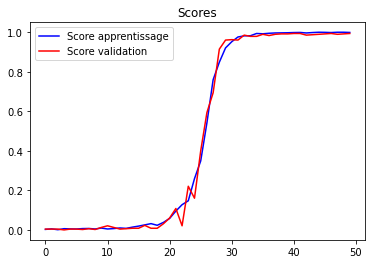

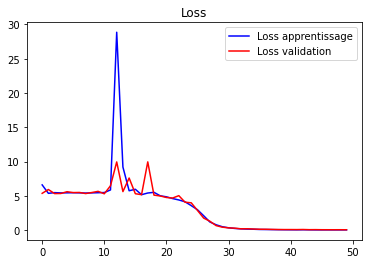

In [20]:
def plot_scores(train):
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Score apprentissage')
    plt.plot(epochs, val_accuracy, 'r', label='Score validation')
    plt.title('Scores')
    plt.legend()
    plt.show()
def plot_loss(train):
    loss = train.history['loss']
    val_loss = train.history['val_loss']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'b', label='Loss apprentissage')
    plt.plot(epochs, val_loss, 'r', label='Loss validation')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
plot_scores(history)
plot_loss(history)